<a href="https://colab.research.google.com/github/kaneelgit/msi_voxceleb/blob/main/Audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
from urllib.request import urlopen
from zipfile import ZipFile

from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt

import os
import glob
import numpy as np
import pandas as pd
import cv2     # for capturing videos
import math
import random

import moviepy.editor as mp
from IPython.display import clear_output

import IPython
import librosa

from scipy.io import wavfile
import os


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2260992/45929032 bytes (4.9%)5283840/45929032 bytes (11.5%)8241152/45929032 bytes (17.9%)11223040/45929032 bytes (24.4%)13934592/45929032 bytes (30.3%)16326656/45929032 bytes (35.5%)19308544/45929032 bytes (42.0%)21954560/45929032 bytes (47.8%)24756224/45929032 bytes (53.9%)27574272/45929032 bytes (60.0%)30613504/45929032 bytes (66.7%)33619968/45929032 bytes (73.2%)

In [4]:
#get url
!wget "https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip"

--2021-10-07 14:27:31--  https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8906971319 (8.3G) [application/zip]
Saving to: ‘vox2_test_mp4.zip’

vox2_test_mp4.zip   100%[===================>]   8.29G  30.7MB/s    in 4m 42s  

2021-10-07 14:32:14 (30.1 MB/s) - ‘vox2_test_mp4.zip’ saved [8906971319/8906971319]



In [ ]:
!unzip vox2_test_mp4.zip

In [6]:
#get video paths
vid_paths = []

for path, directories, files in os.walk('/content/mp4/'):

  for file in files:

    vid_paths.append(str(path) + '/' + str(file))

In [7]:
#number of videos available
print('Number of videos available: ', len(vid_paths))

#shuffle video paths. I have used a random seed of 4 to shuffle.
random.seed(4)
random.shuffle(vid_paths)

Number of videos available:  36237


In [9]:

#some functions to clean the csv file

#del spaces from the ids and gender
def del_spaces(string):
  
  string = string.replace(' ', '')

  return string

#upload csv file from github before running
#open csv file
df = pd.read_csv('/content/vox2_meta.csv')
df.head(5)

#clean the dataset

#apply the function to get rid of spaces
df['VoxCeleb2 ID'] = df['VoxCeleb2 ID'].apply(del_spaces)
df['VGGFace2 ID'] = df['VGGFace2 ID'].apply(del_spaces)
df['Gender'] = df['Gender'].apply(del_spaces)
df['Set'] = df['Set'].apply(del_spaces)


#get the test data
df2 = df[df['Set'] == 'test']
df2['Gender'] = df2['Gender'].astype('category')

df2.head(5)

,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
3,id00017,n000017,m,test
36,id00061,n000061,m,test
53,id00081,n000081,m,test
89,id00154,n000154,m,test
271,id00419,n000419,f,test


In [10]:
#iterate through the vid_paths get the id of the person and get if the person is female or male. If the person is male its a 1 and female its a 0
labels = []

#get only half of the male videos.
count = 0
video_files = []

#iterate
for path in vid_paths:
  
  #get id number
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  if gender == 'm':
    if count % 2 == 0:
      labels.append(1)
      video_files.append(path)
    count += 1
  
  else:
    labels.append(0)
    video_files.append(path)

In [ ]:
# #since i used only 3200 video files to train the video dataset and 150 files for validation, in order to be consistent i will use the same numbers for audio as well. Here i will
# #make 4000 mp3 files and save them in a folder named mp3

# !mkdir mp3

# #labels only 4000
# audio_labels = np.zeros([3500, 1])

# for i, path in enumerate(video_files[:3500]):

#   #label
#   lab = labels[i]

#   #file name
#   file_name = f'{path[13:][:7]}_{str(i).zfill(4)}_{lab}.wav'

#   #get clip and write audio
#   my_clip = mp.VideoFileClip(video_files[3])

#   #get first three seconds
#   my_clip = my_clip.subclip(0, 3)

#   my_clip.audio.write_audiofile(f'/content/mp3/{file_name}')
  
#   #clear output
#   clear_output()
  

[MoviePy] Writing audio in /content/mp3/id03677_3345_1.wav


In [70]:
import time
tick = time.time()
for i in range(12):
  video = mp.VideoFileClip(video_files[i])
  video = video.subclip(0, 3)
  aud = video.audio

  x = aud.to_soundarray()
  
tock = time.time()

print(tock - tick)

2.735682487487793


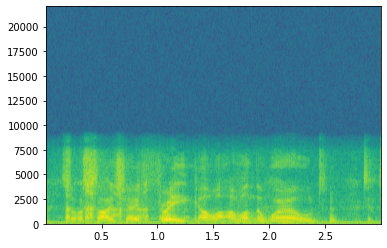

In [83]:
nfft = 300 # Length of each window segment
fs = 44100 # Sampling frequencies
noverlap = 120 # Overlap between windows
#nchannels = data.ndim

pxx, freqs, bins, im = plt.specgram(x[:,0], nfft, fs, noverlap = noverlap)

In [84]:
pxx.shape

(151, 734)

In [87]:
224 * 224 * 3

150528

In [86]:
151 * 734

110834